In [314]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *
from FRSolver import * 

%matplotlib inline

def Peturb(r0s, v0s, epsilon):
    w0s = vec_to_w(r0s, v0s)

    # Step 1: Generate a random direction vector
    random_direction = np.random.uniform(-1, 1, size=w0s.shape)

    # Step 2: Normalize the random direction vector
    random_direction /= np.linalg.norm(random_direction)

    # Step 3: Scale the normalized random direction vector by epsilon
    perturbation = epsilon * random_direction

    # Step 4: Add the perturbation to the original vector
    w0sprime = w0s + perturbation

    r0sprime, v0sprime = w_to_vec(w0sprime)

    return r0sprime, v0sprime


def LyapunovExponent(Nestimates, Nsteps, epsilon, r0s, v0s, C, hlim = 1e-10):

    r0sprime, v0sprime = Peturb(r0s, v0s, epsilon)
    estimates = []
    t_vals = []
    all_diffs = []
    final_t = 0
    d1s = []
    exponents = []
    for i in range(Nestimates):
        traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
        trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

        t_vals = t_vals + list(np.array(traj[0]) + final_t)
        final_t = t_vals[-1]

        rs_traj = traj[1]
        vs_traj = traj[2]

        rs_traj_prime = trajprime[1]
        vs_traj_prime = trajprime[2]

        ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
        ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])

        w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)
        d1s.append(w_diffs[-1])
        exponents.append((1/ final_t) * np.sum(np.log(np.array(d1s)/epsilon)))

        all_diffs = all_diffs + list(w_diffs)

        w0s = ws[-1]
        w0sprime = ws[-1] + epsilon * (ws_prime[-1] - ws[-1]) / w_diffs[-1]

        r0s, v0s = w_to_vec(w0s)
        r0sprime, v0sprime = w_to_vec(w0sprime)
        
    return exponents, d1s, all_diffs, t_vals

In [340]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

epsilon = 1e-4
Rprime = R + epsilon

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

r0sprime, v0sprime = Peturb(r0s, v0s, epsilon)

In [316]:
print(r0sprime)

[[-9.99979823e-01  2.48321362e-05  6.53141928e-06]
 [ 2.34777389e-05  2.41530661e-05 -3.40285364e-05]
 [ 9.99998075e-01 -8.44286361e-06  3.29572661e-05]]


In [317]:
Nsteps = 1000
C = 1e-5
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]
t_vals_prime = trajprime[0]

h_vals = np.diff(t_vals)
h_vals_prime = np.diff(t_vals_prime)

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)

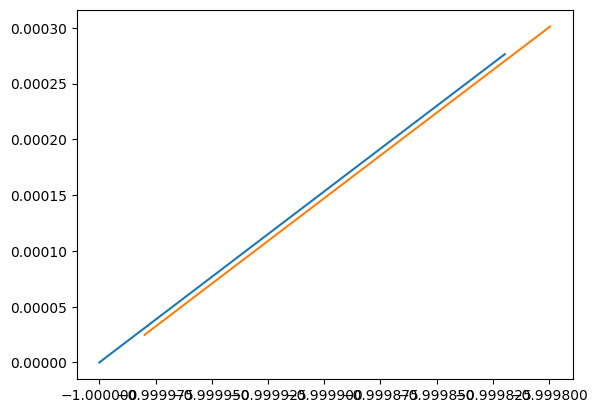

In [318]:
plt.plot(rs_traj[:100, 0, 0], rs_traj[:100,0,1])
plt.plot(rs_traj_prime[:100, 0, 0], rs_traj_prime[:100,0,1])

In [319]:
traj_diff = rs_traj - rs_traj_prime
traj_diff = np.linalg.norm(traj_diff[:,0], axis = 1) 

In [320]:
vs_traj_diff = vs_traj - vs_traj_prime
vs_traj_diff = np.linalg.norm(vs_traj_diff[:,0], axis = 1) 

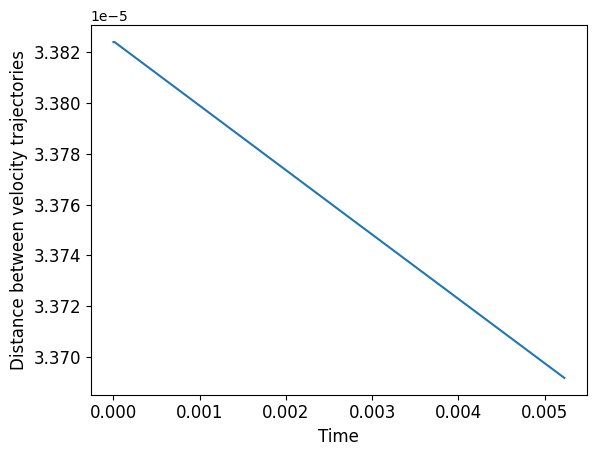

In [321]:
fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between velocity trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.plot(t_vals[1:], h_vals)
ax.plot(t_vals, vs_traj_diff)

plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8mass1VelocityDiff.pdf' , bbox_inches='tight')

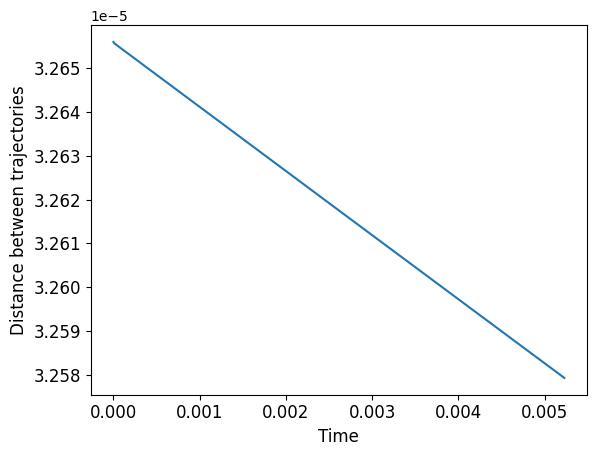

In [322]:
traj_diff = rs_traj - rs_traj_prime
traj_diff = np.linalg.norm(traj_diff[:,0], axis = 1) 

fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.plot(t_vals[1:], h_vals)
ax.plot(t_vals, traj_diff)

plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8mass1diff.pdf', bbox_inches='tight')

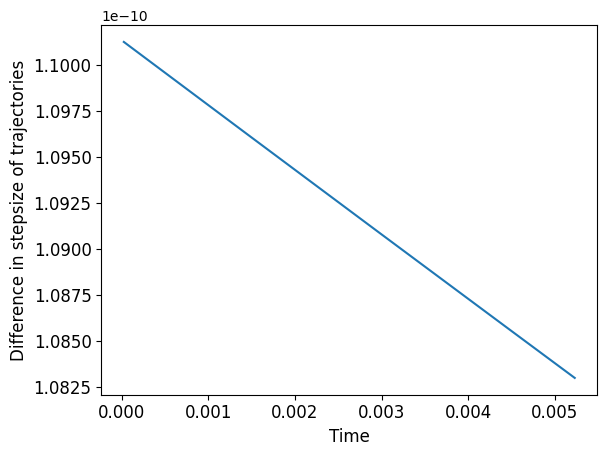

In [323]:
fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Difference in stepsize of trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.plot(t_vals[1:], h_vals)
ax.plot(t_vals[5:], h_vals_prime[4:] - h_vals[4:])

plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8StepsizedDiff.pdf', bbox_inches='tight')

9.999999999998377e-05


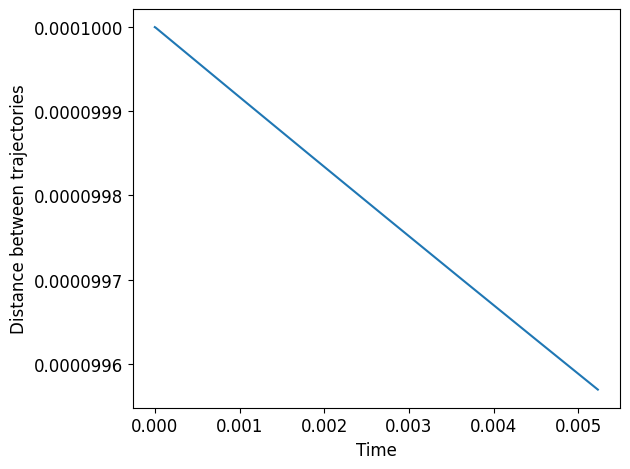

In [324]:
ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
print(np.linalg.norm(ws[0] - ws_prime[0]))


fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals, w_diffs)

plt.tight_layout()

plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8PhaseDiff.pdf', bbox_inches='tight')

#### LONG TERM ANALYSIS

In [341]:
Nsteps = 200 * 1
C = 1e-1
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]
t_vals_prime = trajprime[0]

h_vals = np.diff(t_vals)
h_vals_prime = np.diff(t_vals_prime)

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)

9.99999999999709e-05


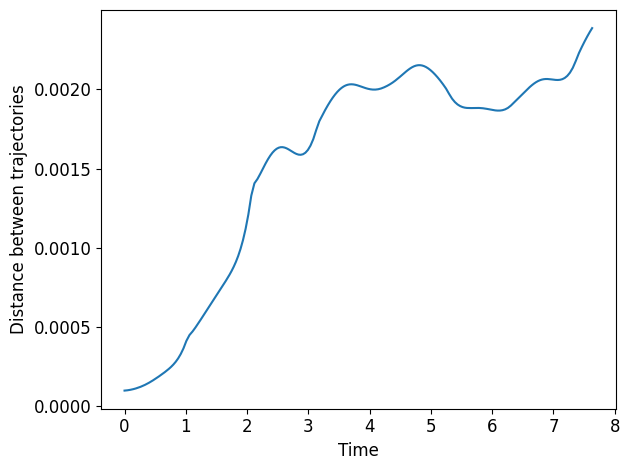

In [342]:
ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
print(np.linalg.norm(ws[0] - ws_prime[0]))


fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals, w_diffs)

plt.tight_layout()

plt.savefig('Plots/Lyapunov/PertubationAnalysis/OneOrbitFig8Diffs.pdf', bbox_inches='tight')

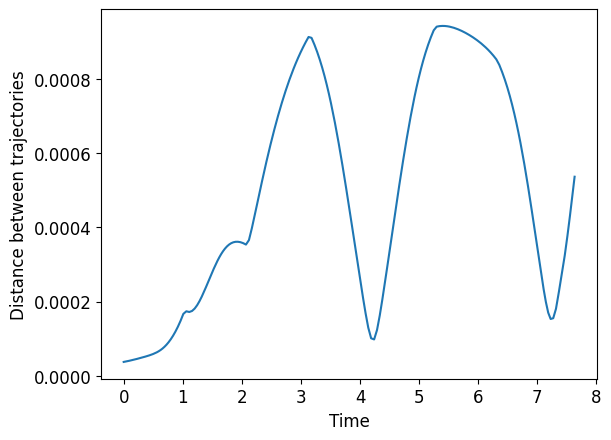

In [343]:
traj_diff = rs_traj - rs_traj_prime
traj_diff = np.linalg.norm(traj_diff[:,0], axis = 1) 

fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.plot(t_vals[1:], h_vals)
ax.plot(t_vals, traj_diff)

plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8mass1diffOnePeriod.pdf', bbox_inches='tight')

In [344]:
Nsteps = 200 * 100
C = 1e-1
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]
t_vals_prime = trajprime[0]

h_vals = np.diff(t_vals)
h_vals_prime = np.diff(t_vals_prime)

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)

9.99999999999709e-05


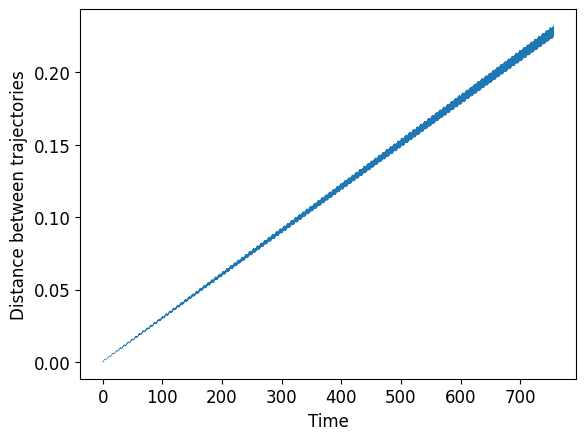

In [354]:
ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
print(np.linalg.norm(ws[0] - ws_prime[0]))


fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals, w_diffs, linewidth = 0.5)


plt.savefig('Plots/Lyapunov/PertubationAnalysis/100OrbitsFig8Diffs.pdf', bbox_inches='tight')

In [355]:
exponents = np.array([(1/t_vals[i]) * np.log(w_diffs[i] / w_diffs[0]) for i in range(1, len(w_diffs))])

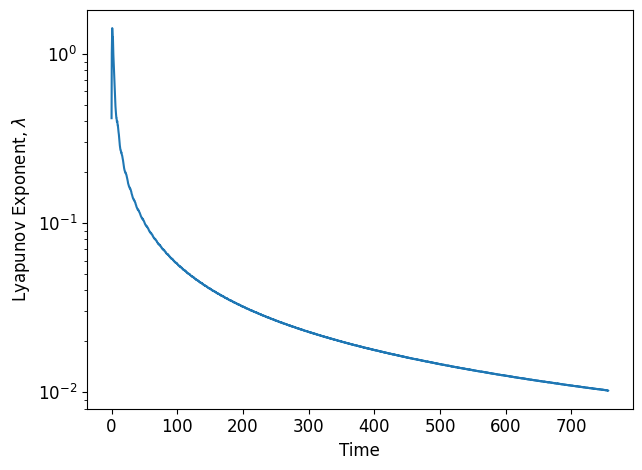

In [356]:
exponents = np.array([(1/t_vals[i]) * np.log(w_diffs[i] / w_diffs[0]) for i in range(1, len(w_diffs))])

fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel(r'Lyapunov Exponent, $\lambda$', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals[1:], exponents)

plt.tight_layout()
ax.set_yscale('log')

plt.savefig('Plots/Lyapunov/PertubationAnalysis/InitialExponentEstimate.pdf', bbox_inches='tight')

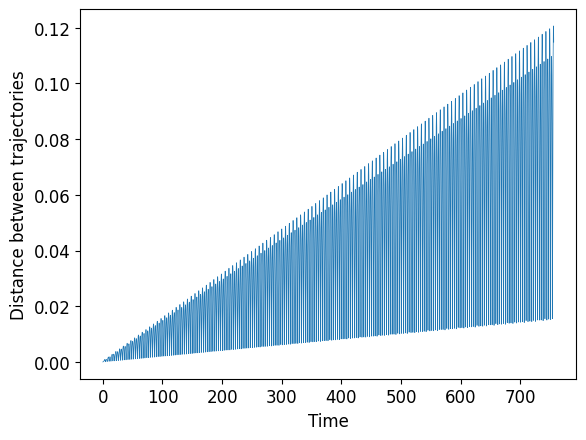

In [357]:
traj_diff = rs_traj - rs_traj_prime
traj_diff = np.linalg.norm(traj_diff[:,0], axis = 1) 

fig, ax = plt.subplots()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.plot(t_vals[1:], h_vals)
ax.plot(t_vals, traj_diff, linewidth = 0.5)

plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8mass1diff100Periods.pdf', bbox_inches='tight')

#### LONG TERM ESTIMATE

In [358]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

epsilon = 1e-8
Rprime = R + epsilon

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

r0sprime, v0sprime = Peturb(r0s, v0s, epsilon)

In [359]:
Nsteps = 200 * 500
C = 1e-1
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]
t_vals_prime = trajprime[0]

h_vals = np.diff(t_vals)
h_vals_prime = np.diff(t_vals_prime)

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)

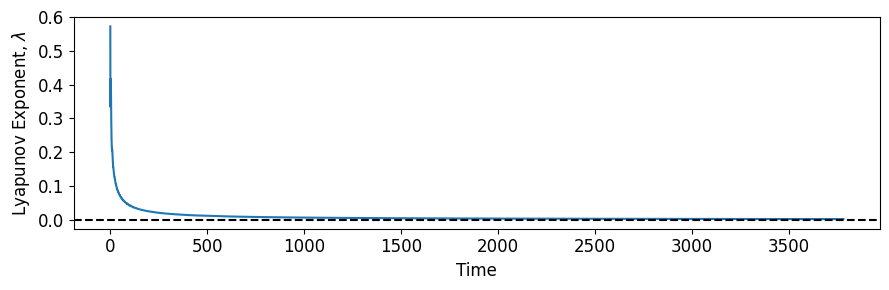

In [393]:
exponents = np.array([(1/t_vals[i]) * np.log(w_diffs[i] / w_diffs[0]) for i in range(1, len(w_diffs))])

fig, ax = plt.subplots(figsize = (9, 3))
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel(r'Lyapunov Exponent, $\lambda$', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals[1:], exponents)

plt.tight_layout()
# ax.set_yscale('log')

plt.axhline(y=0, color='black', linestyle='--')
plt.savefig('Plots/Lyapunov/PertubationAnalysis/Fig8ExponentEstimate.pdf', bbox_inches='tight')

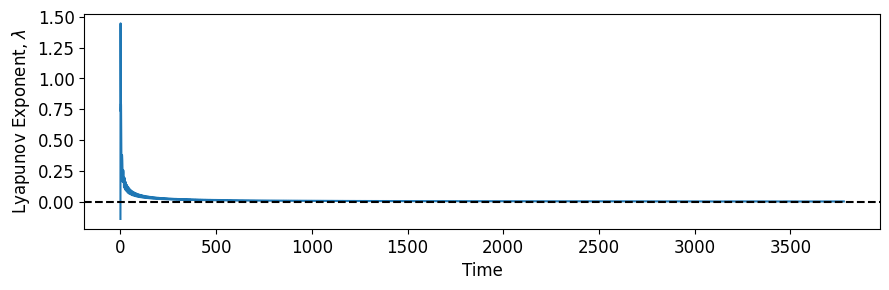

In [390]:
traj_diffs = rs_traj - rs_traj_prime
traj_diffs = np.linalg.norm(traj_diffs[:,0], axis = 1) 

exponents = np.array([(1/t_vals[i]) * np.log(traj_diffs[i] / traj_diffs[0]) for i in range(1, len(traj_diffs))])

fig, ax = plt.subplots(figsize = (9, 3))
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel(r'Lyapunov Exponent, $\lambda$', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals[1:], exponents)

plt.tight_layout()
# ax.set_yscale('log')

plt.axhline(y=0, color='black', linestyle='--')

#### ESTIMATING EXPONENT

In [333]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

epsilon = 1e-5
Rprime = R + epsilon

# position
r1prime = np.array([-Rprime,0.0,0.0], dtype="float64")
r2prime = np.array([0,0.0,0.0], dtype="float64")
r3prime = np.array([R,0.0,0.0], dtype="float64")

r0sprime = np.array([r1prime, r2prime, r3prime])

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# velocity 
v1prime = np.array([px2,py2,0], dtype="float64")
v2prime = np.array([-2 * px2,-2*py2,0], dtype="float64")
v3prime = np.array([px2,py2,0], dtype="float64")

v0sprime = np.array([v1prime,v2prime,v3prime])

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [334]:
Nestimates = 200
Nsteps = 100
C = 1e-1
epsilon = 1e-5

In [335]:
exponents, d1s, all_diffs, t_vals = LyapunovExponent(Nestimates, Nsteps, epsilon, r0s, v0s, C)

0.03108541748231782


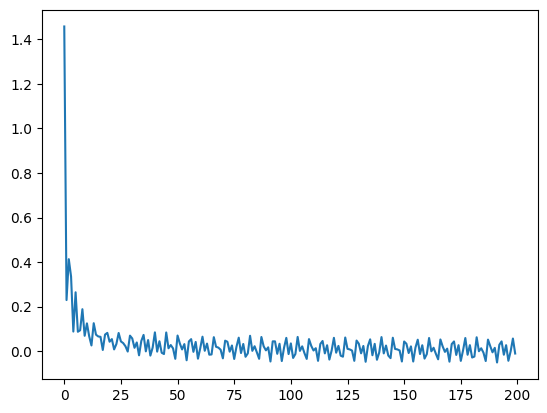

In [336]:
plt.plot(np.log(np.array(d1s)/epsilon))
print(np.mean(np.log(np.array(d1s)/epsilon)))

0.008143583434502546


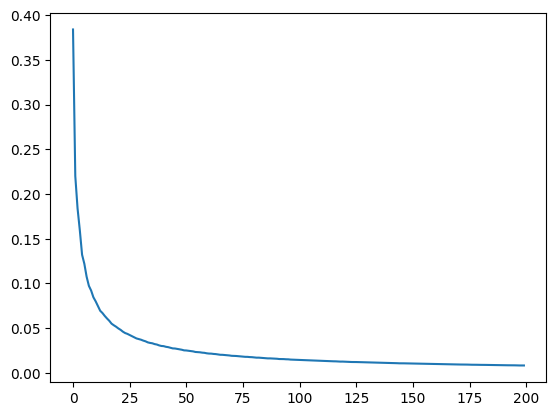

In [337]:
plt.plot(exponents)
print(exponents[-1])

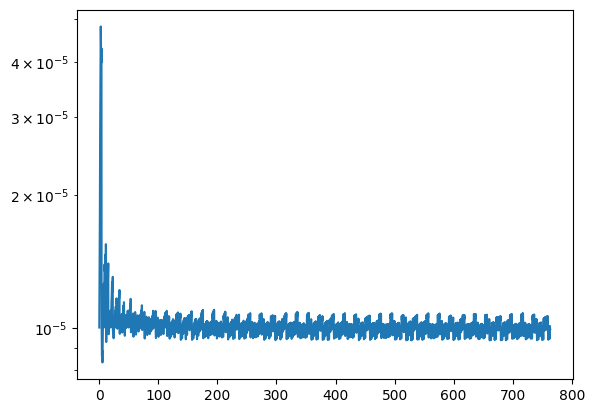

In [338]:
plt.plot(t_vals, all_diffs)
plt.yscale('log')

In [339]:
w_lims = np.array([(1/t_vals[i]) * lims[i] for i in range(1, len(lims))])

NameError: name 'lims' is not defined

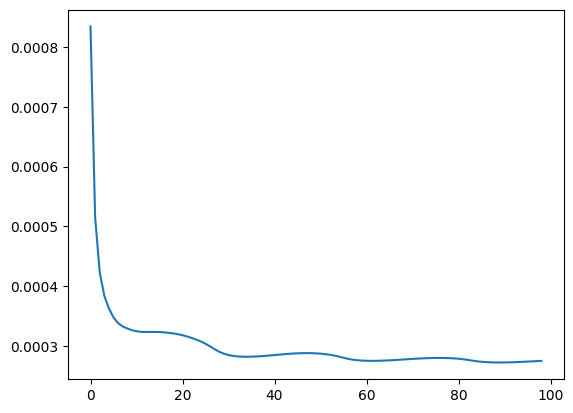

In [ ]:
plt.plot(w_lims)

In [ ]:
print(w_lims[-1])

0.00027488990260813104


#### EULER

In [ ]:
# gravity
G = 1

m1 = 1
m2 = 1
m3 = 1

R = 1 
# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")
 
w = np.sqrt(1.25)
# velocity 
v1 = w* np.array([0,-1,0], dtype="float64")
v2 = w* np.array([0,0,0], dtype="float64")
v3 = w* np.array([0,1,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

epsilon = 1e-8
Rprime = R + epsilon

# position
r1prime = np.array([-Rprime,0.0,0.0], dtype="float64")
r2prime = np.array([0,0.0,0.0], dtype="float64")
r3prime = np.array([R,0.0,0.0], dtype="float64")

r0sprime = np.array([r1prime, r2prime, r3prime])

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
v0sprime = v0s.copy()
masses = np.array([m1, m2, m3])

In [ ]:
Nsteps = 1000
C = 1e-4
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

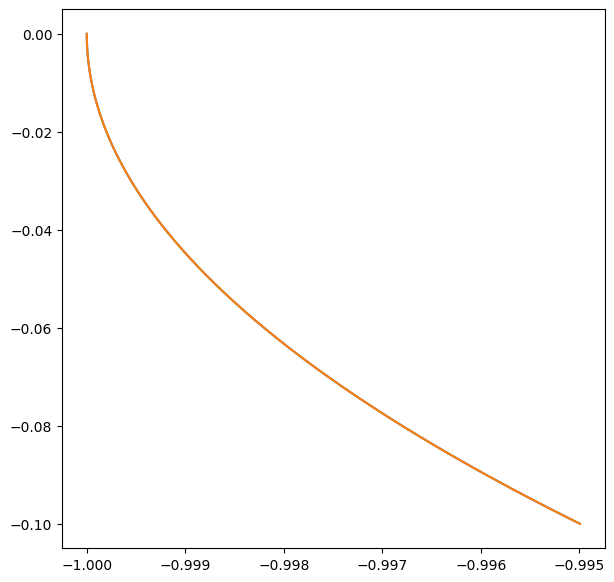

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))

ax.plot(rs_traj[:,0,0], rs_traj[:,0,1])
ax.plot(rs_traj_prime[:,0,0], rs_traj_prime[:,0,1])

In [ ]:
traj_diff = rs_traj - rs_traj_prime
traj_diff = np.linalg.norm(traj_diff[:,0], axis = 1) 

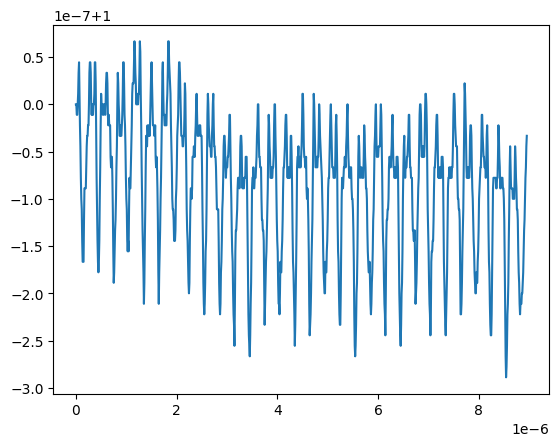

In [ ]:
plt.plot(t_vals, traj_diff / traj_diff[0])

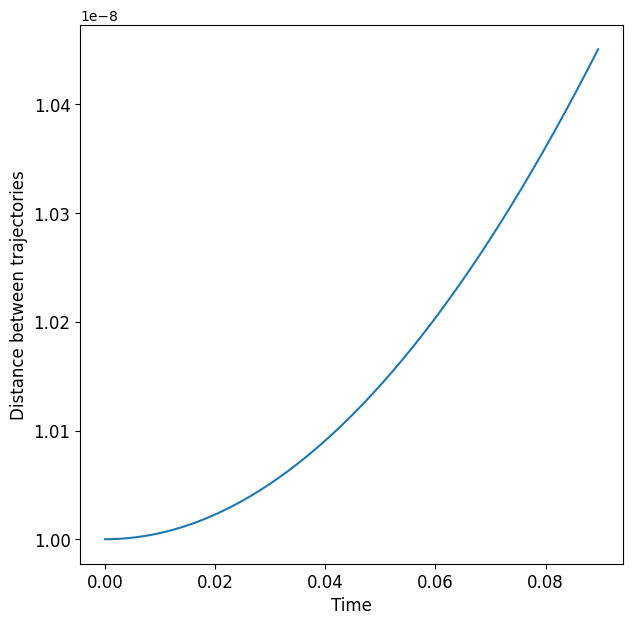

In [ ]:
ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])

w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)

w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)
fig, ax = plt.subplots(figsize = (7,7))
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals, w_diffs)

In [ ]:
w_lims = np.array([(1/t_vals[i]) * lims[i] for i in range(1, len(lims))])

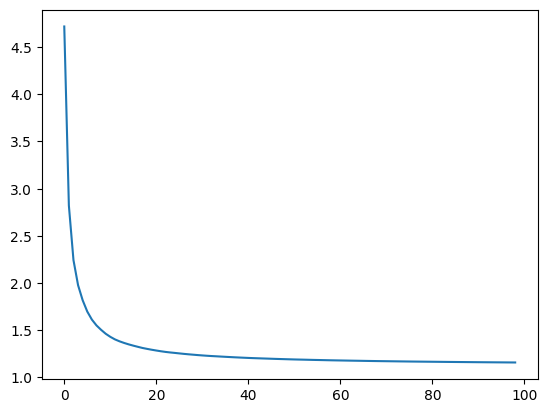

In [ ]:
plt.plot(w_lims)

In [ ]:
N_estimates = 200
C = 1e-1

estimates = []
t_vals = []
all_diffs = []
final_t = 0
Nsteps = 100
d1s = []
for i in range(N_estimates):
    traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
    trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

    t_vals = t_vals + list(np.array(traj[0]) + final_t)
    final_t = t_vals[-1]

    rs_traj = traj[1]
    vs_traj = traj[2]

    rs_traj_prime = trajprime[1]
    vs_traj_prime = trajprime[2]

    ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
    ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])

    w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)
    d1s.append(w_diffs[-1])

    all_diffs = all_diffs + list(w_diffs)

    w0s = ws[-1]
    w0sprime = ws[-1] + epsilon * (ws_prime[-1] - ws[-1]) / w_diffs[-1]

    r0s, v0s = w_to_vec(w0s)
    r0sprime, v0sprime = w_to_vec(w0sprime)

12.902965689012985


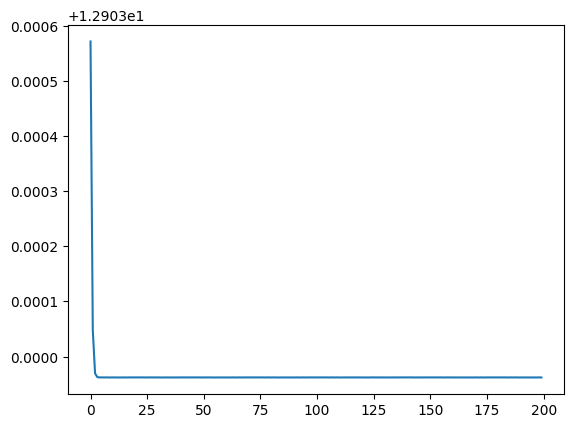

In [ ]:
plt.plot(np.log(np.array(d1s)/epsilon))
print(np.mean(np.log(np.array(d1s)/epsilon)))

#### LAGRANGE

In [ ]:
# gravity
G = 1

m1 = 1
m2 = 1
m3 = 1

w = 0.75984

# position
r1 = np.array([0,1,0], dtype="float64")
r2 = np.array([- np.cos(np.pi / 6), - np.sin(np.pi / 6),0.0], dtype="float64")
r3 = np.array([np.cos(np.pi / 6), - np.sin(np.pi / 6),0.0], dtype="float64")

# velocity 
v1 = w * np.array([-1, 0, 0], dtype="float64")
v2 = w * np.array([np.sin(np.pi / 6),-np.cos(np.pi / 6),0], dtype="float64")
v3 = w* np.array([np.sin(np.pi / 6),np.cos(np.pi / 6),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

r0sprime, v0sprime = Peturb(r0s, v0s, epsilon)

In [ ]:
Nsteps = 10000
C = 1e-4
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])
w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)

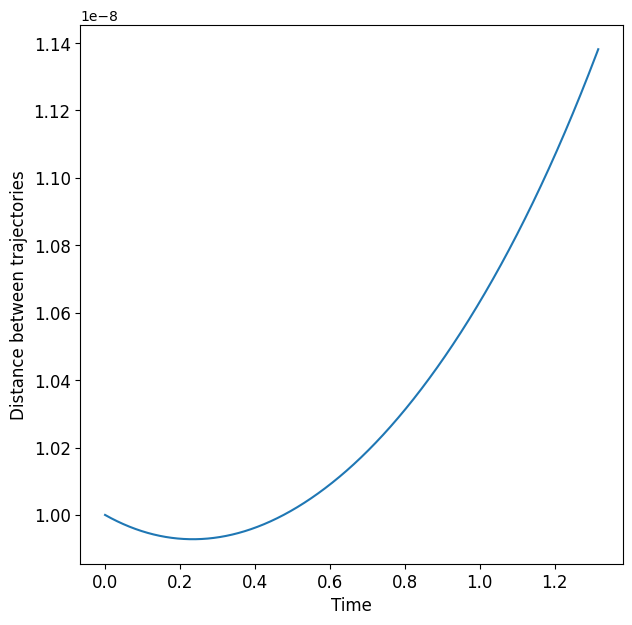

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Distance between trajectories', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.plot(t_vals, w_diffs)

In [ ]:
Nestimates = 5000
Nsteps = 10
epsilon = 1e-5

In [ ]:
exponents, d1s, all_diffs, t_vals = LyapunovExponent(Nestimates, Nsteps, epsilon, r0s, v0s, C)

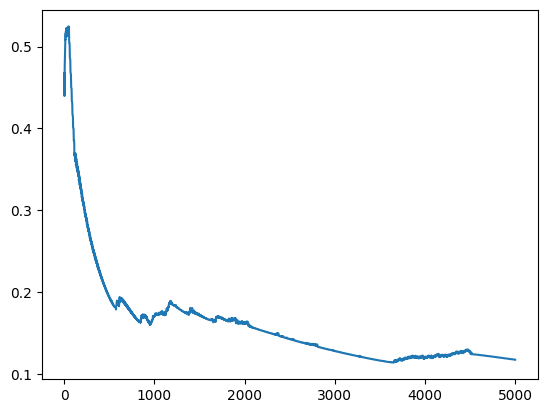

In [ ]:
plt.plot(exponents)

#### MOTH 

In [ ]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")
r3 = np.array([-1,0.0,0.0], dtype="float64")

p1 = 0.347111
p2 = 0.532728

# velocity 
v1 = np.array([-2 * p1,-2*p2,0], dtype="float64")
v2 = np.array([p1,p2,0], dtype="float64")
v3 = np.array([p1,p2,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])

masses = np.array([m1, m2, m3])

E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

pxhat = p1 + 0.103503736 
pyhat = p2  -0.15137638399999997

# velocity 
v1hat = np.array([pxhat,pyhat,0], dtype="float64")
v2hat = np.array([-2 * pxhat,-2*pyhat,0], dtype="float64")
v3hat = np.array([pxhat,pyhat,0], dtype="float64") 
v0s = np.array([v1hat,v2hat,v3hat])
v0sprime = v0s.copy()

R = findR(v0shat, E0, masses)
epsilon = 1e-5
Rprime = R + epsilon 

# position
r1hat = np.array([-R,0.0,0.0], dtype="float64") 
r2hat = np.array([0,0.0,0.0], dtype="float64")
r3hat = np.array([R,0.0,0.0], dtype="float64")
r0s = np.array([r1hat,r2hat,r3hat])

# position
r1hat = np.array([-Rprime,0.0,0.0], dtype="float64") 
r2hat = np.array([0,0.0,0.0], dtype="float64")
r3hat = np.array([R,0.0,0.0], dtype="float64")
r0sprime = np.array([r1hat,r2hat,r3hat])


rcom, vcom = CentreOfMass(r0shat, v0shat, masses)
v0shat -= vcom
r0shat -= rcom

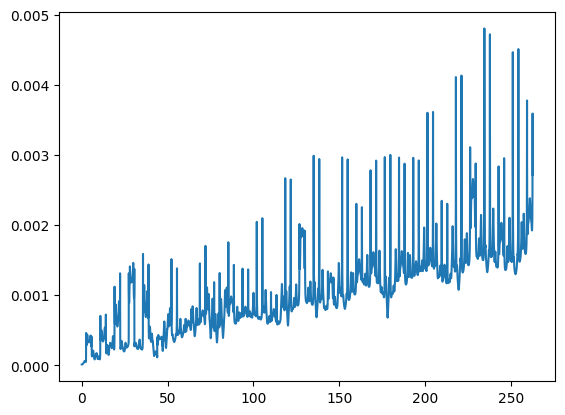

In [ ]:
Nsteps = 10000
C = 1e-1
hlim = 1e-10

traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

t_vals = traj[0]

rs_traj = traj[1]
vs_traj = traj[2]

rs_traj_prime = trajprime[1]
vs_traj_prime = trajprime[2]

ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])

w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)
plt.plot(t_vals, w_diffs)

In [ ]:
N_estimates = 200
C = 1e-1

estimates = []
t_vals = []
all_diffs = []
final_t = 0
Nsteps = 100
d1s = []
exponents = []
for i in range(N_estimates):
    traj, _ = NStepsSolver(Nsteps, C, r0s, v0s, G, masses, hlim = hlim)
    trajprime, _ = NStepsSolver(Nsteps, C, r0sprime, v0sprime, G, masses, hlim = hlim)

    t_vals = t_vals + list(np.array(traj[0]) + final_t)
    final_t = t_vals[-1]

    rs_traj = traj[1]
    vs_traj = traj[2]

    rs_traj_prime = trajprime[1]
    vs_traj_prime = trajprime[2]

    ws = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
    ws_prime = np.array([vec_to_w(rs_traj_prime[i], vs_traj_prime[i]) for i in range(len(rs_traj_prime))])

    w_diffs = np.linalg.norm(ws-ws_prime, axis = 1)
    d1s.append(w_diffs[-1])
    exponents.append((1/ final_t) * np.sum(np.log(np.array(d1s)/epsilon)))

    all_diffs = all_diffs + list(w_diffs)

    w0s = ws[-1]
    w0sprime = ws[-1] + epsilon * (ws_prime[-1] - ws[-1]) / w_diffs[-1]

    r0s, v0s = w_to_vec(w0s)
    r0sprime, v0sprime = w_to_vec(w0sprime)

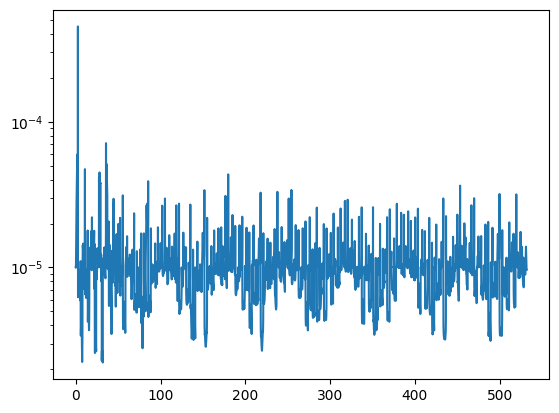

In [ ]:
plt.plot(t_vals, all_diffs)
plt.yscale('log')

0.029410890816837832


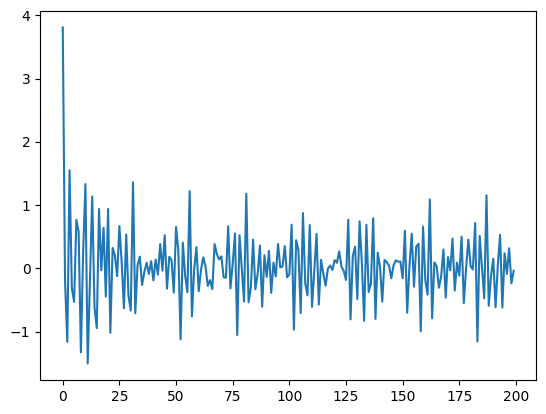

In [ ]:
plt.plot(np.log(np.array(d1s)/epsilon))
print(np.mean(np.log(np.array(d1s)/epsilon)))

0.011059658750575345


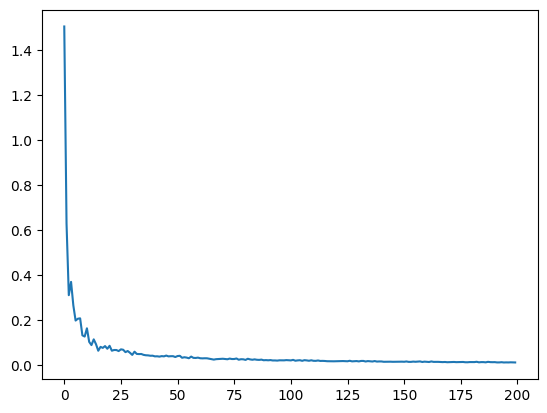

In [ ]:
plt.plot(exponents)
print(exponents[-1])

#### SPECTRUM

In [ ]:
def GS(vectors):
    num_vectors, vector_dim = vectors.shape
    ortho_vectors = np.zeros((num_vectors, vector_dim))

    for i in range(num_vectors):
        ortho_vectors[i] = vectors[i]

        for j in range(i):
            proj = np.dot(vectors[i], ortho_vectors[j])
            ortho_vectors[i] -= proj * ortho_vectors[j]
        
        # Check for zero norm to prevent division by zero
        norm = np.linalg.norm(ortho_vectors[i])
        if norm > 1e-8:
            ortho_vectors[i] /= norm

    return ortho_vectors

def LyapunovSpectrum(rs_traj, vs_traj, G, masses):
    num_time_steps, num_bodies, num_dims = rs_traj.shape
    ws_traj = np.array([vec_to_w(rs_traj[i], vs_traj[i]) for i in range(len(rs_traj))])
    exponents = np.zeros_like(ws_traj[0])
    num_exponents = len(exponents)
    tangent_vectors = np.eye(num_exponents)

    for i in range(num_time_steps):
        derivs = all_derivatives(ws_traj[i], t_vals[i], G, masses)

        derivative_matrix = np.zeros((num_exponents, num_exponents))

        # Create the derivative matrix by reshaping the derivatives
        for j in range(num_bodies):
            derivative_matrix[j*num_dims : (j+1)*num_dims, j*num_dims : (j+1)*num_dims] = derivs[j*num_dims : (j+1)*num_dims]

        # print(derivative_matrix)
        
        # Update tangent vectors using the derivative
        tangent_vectors = np.matmul(derivative_matrix, tangent_vectors)

        # Perform Gram-Schmidt orthogonalization
        tangent_vectors = GS(tangent_vectors)

        print('GS', tangent_vectors)

        # Renormalize the tangent vectors
        tangent_vectors /= np.linalg.norm(tangent_vectors, axis=0)

        # Calculate the Lyapunov exponents as time averages
        exponents += np.log(np.linalg.norm(tangent_vectors, axis=0))

    exponents /= num_time_steps

    return exponents